In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
import datetime as dt
import boto3, yaml
from datetime import timedelta

from sklearn.model_selection import TimeSeriesSplit,train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize, MinMaxScaler
from imblearn.over_sampling import SMOTE
import sys,os

from joblib import dump, load

util_path = os.path.abspath(os.path.join(os.path.pardir, '../sasse-polygon-process/lib'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)
    
from config import read_options
from util import plot_class_hist 

sns.set()
sns.set_style("whitegrid")
%matplotlib inline

Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ec2-u

# Initialize

In [2]:
class Options(): pass

options = Options()
options.config_filename = '../cnf/rfc.ini'
options.config_name = 'forest'
read_options(options)

options_thin = Options()
options_thin.config_filename = '../cnf/rfc.ini'
options_thin.config_name = 'thin'
read_options(options_thin)

In [3]:
def save_model(model, fname, remote_name):
    """ Save model and upload it to bucket """
    
    save_path = os.path.dirname(os.path.abspath(fname))

    if not os.path.exists(save_path):
        os.mkdir(save_path)
    
    dump(model, fname)
    
    s3 = boto3.resource('s3')
    s3.meta.client.upload_file(fname, 'fmi-asi-sasse-assets', remote_name)

In [4]:
def classify(dataset, limits=None, based_on='outages'):
    # outages
    if limits is None:
        limits = [(0,0), (1,5), (5, 9999999)]
        
    i = 0
    for low, high in limits:
        dataset.loc[(dataset.loc[:, based_on] >= low) & (dataset.loc[:, based_on] <= high), 'class'] = i
        i += 1
        
    return dataset

In [5]:
def get_data(file_, options, name, scaler=None, verbose=False, limits=None, shuffle=True, test_size=.25, time_range=None, limit=15):
    """ Read and normalise data """
        
    data = pd.read_csv(file_)
    
    data = data.loc[(data['weather_parameter'] == 'WindGust') & (data['low_limit'] == limit)].fillna(0)
    
    # Forest data gathering process have been ran twice for some cases. We have duplicate rows in the data.
    data.drop_duplicates(subset='id', inplace=True)
        
    label = options.label[0]
    
    data['point_in_time'] = pd.to_datetime(data['point_in_time'])        
    data['week'] = data['point_in_time'].dt.week

    missing = list(set(options.feature_params + options.meta_params + options.label)-set(data.columns.values))
    if len(missing) > 0:
        raise ValueError("Missing parameter(s) {}".format(','.join(missing)))
    
    if limits is not None:
        data = classify(data, limits)
    
    if shuffle:
        y = data.loc[:, options.label].values.ravel()
        data_train, data_test, _, __ = train_test_split(data, y, stratify=y, shuffle=shuffle, test_size=test_size, train_size=1-test_size)
    else:
        data.sort_values(by='point_in_time', inplace=True)
        # With time range
        if time_range is not None:
            # Prepare
            data.loc[:,'point_in_time'] = pd.to_datetime(data['point_in_time'])
            data.set_index('point_in_time', drop=True, inplace=True)
            data.index = data.index.tz_convert(tz='Europe/Helsinki')
            # Keep time during merge
            data.loc[:,'t'] = data.index
            # Select test range
            data_test = data[time_range[0]:time_range[1]]
            # Select rest to train 
            df_all = data.merge(data_test.drop_duplicates(), how='left', indicator=True)
            data_train = df_all[(df_all['_merge'] == 'left_only')]
            # Reset point in time
            data_train.loc[:, 'point_in_time'] = data_train['t']
            data_test.loc[:,'point_in_time'] = data_test['t']
        else:
        # With timeseries split
            splits = list(TimeSeriesSplit(n_splits=int(1/test_size)).split(data))
            data_train, data_test = data.iloc[splits[-1][0],:], data.iloc[splits[-1][1],:]
    
    # For analysis
    if verbose:
        for c in [1,2,3]:
            print('Dates in testset class {}:'.format(c))
            for i, row in data_test[(data_test['class']==c)].iterrows():
                print(row.point_in_time, end=',')
            print("\n")    
    
    X_train = data_train.loc[:, options.feature_params]
    y_train = data_train.loc[:, options.label]
    meta_train = data_train.loc[:, options.meta_params]

    X_test = data_test.loc[:, options.feature_params]
    y_test = data_test.loc[:, options.label]
    meta_test = data_test.loc[:, options.meta_params]
    
    # Scale
    if scaler is None:
        scaler = StandardScaler()      
    
    try:
        X_train = pd.DataFrame(scaler.transform(X_train), columns=options.feature_params)
    except:
        local_name = '../data/models/scaler/{}.joblib'.format(name)
        remote_name = 'models/scaler/{}.joblib'.format(name)
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=options.feature_params)
        save_model(scaler, local_name, remote_name)
        print('Saved scaler scaler {} and uploaded it to {}'.format(local_name, remote_name))

    X_test = pd.DataFrame(scaler.transform(X_test), columns=options.feature_params)
            
    sm = SMOTE()
    X_res, y_res = sm.fit_resample(X_train, y_train)
    
    train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True), meta_train.reset_index(drop=True)], axis=1)
    test = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True), meta_test.reset_index(drop=True)], axis=1)
    res = pd.concat([pd.DataFrame(X_res, columns=options.feature_params), pd.DataFrame(y_res, columns=options.label)], axis=1)
    
    return train, test, res, scaler

In [6]:
def cut_classes(dataset, classes, max_size, label): 
    """ Decrease dataset size by cutting requested classes smaller """
    
    # Cherry picked classes
    class_dfs = []
    for c in classes: 
        picked_data = dataset.loc[(dataset.loc[:,label] == c),:].reset_index(drop=True)
        class_dfs.append(picked_data.loc[0:min(len(picked_data), max_size),:])
        #class_dfs.append(picked_data.sample(n=min(len(picked_data), max_size)))

    # Concat
    data = pd.concat(class_dfs)
    return data

In [7]:
def save_dataset(datasets):
    """ Save data to local filesystem and S3 """
    
    for name, data in datasets:
        filename = '../data/{}.csv'.format(name)
        remote_name = 'data/{}.csv'.format(name)

        data.to_csv(filename, index=False)
        
        s3 = boto3.resource('s3')
        s3.meta.client.upload_file(filename, 'fmi-asi-sasse-assets', remote_name)

# Loiste - JSE 2017-2018

1. Read whole dataset
1. Re-classify it to three classes. Limit 1-3 for class 1 is selected so that class 1 contain 80 % of all cases with at least 1 outage.
1. Split to train (70 %) and test set (70 %) (randomly)
1. Create smaller training set by limiting class sizes to maximum limit (smaller classes are not affected). Testset remain the same.

In [8]:
# Ensure that 1-3 outages cover 80 % of all outages cases
data = pd.read_csv('../data/classification_dataset_loiste_jse_forest.csv')
print(len(data[(data['outages'] > 0) & (data['outages'] < 3)])/len(data[(data['outages'] > 0)]))
print(len(data[(data['outages'] == 0)])/len(data))
print(len(data[(data['outages'] > 0) & (data['outages'] < 140)])/len(data))

0.7926364790520525
0.9037160785592047
0.09628392144079537


In [9]:
#print('All params:')
limits = [(0,0), (1,3), (3, 9999999)]
test_size=.1
shuffle=False
time_range=('2017-01-01', '2018-12-31')

object_limits = [15, 20]
datasets = {}
scalers = {}

for limit in object_limits:
    name = 'loiste_jse_recent_{}'.format(limit)

    ds = get_data('../data/classification_dataset_loiste_jse_forest.csv', 
                  options, 
                  '{}_all'.format(name),
                  verbose=False, 
                  limits=limits,
                  shuffle=shuffle,
                  test_size=test_size,
                  time_range=time_range,
                  limit=limit)
    datasets[name+'_all_train'], datasets[name+'_all_test'], datasets[name+'_all_res'], scalers[name+'_all'] = ds    

    ds =get_data('../data/classification_dataset_loiste_jse_forest.csv', 
                options_thin, 
                '{}_thin'.format(name), 
                verbose=False, 
                limits=limits,
                shuffle=shuffle,
                test_size=test_size,
                time_range=time_range,
                limit=limit)
    datasets[name+'_thin_train'], datasets[name+'_thin_test'], datasets[name+'_thin_res'], scalers[name+'_thin'] = ds    

    datasets[name+'_small_train'] = cut_classes(datasets[name+'_all_train'], [0,1,2], 1000, options.label[0]) 
    datasets[name+'_small_thin_train'] = cut_classes(datasets[name+'_thin_train'], [0,1,2], 1000, options.label[0]) 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Saved scaler scaler ../data/models/scaler/loiste_jse_recent_15_all.joblib and uploaded it to models/scaler/loiste_jse_recent_15_all.joblib


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Saved scaler scaler ../data/models/scaler/loiste_jse_recent_15_thin.joblib and uploaded it to models/scaler/loiste_jse_recent_15_thin.joblib


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Saved scaler scaler ../data/models/scaler/loiste_jse_recent_20_all.joblib and uploaded it to models/scaler/loiste_jse_recent_20_all.joblib
Saved scaler scaler ../data/models/scaler/loiste_jse_recent_20_thin.joblib and uploaded it to models/scaler/loiste_jse_recent_20_thin.joblib


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [10]:
for limit in object_limits: 
    name = 'loiste_jse_recent_{}'.format(limit)
    dfdup = pd.concat([datasets[name+'_all_train'].loc[:, options.feature_params], datasets[name+'_all_test'].loc[:, options.feature_params]])
    assert len(dfdup[(dfdup.duplicated())]) == 0
    
    name = 'loiste_jse_recent_{}'.format(limit)
    dfdup = pd.concat([datasets[name+'_small_thin_train'].loc[:, options_thin.feature_params], datasets[name+'_thin_test'].loc[:, options_thin.feature_params]])
    assert len(dfdup[(dfdup.duplicated())]) == 0
    
    name = 'loiste_jse_recent_{}'.format(limit)
    dfdup = pd.concat([datasets[name+'_small_train'].loc[:, options.feature_params], datasets[name+'_all_test'].loc[:, options.feature_params]])
    assert len(dfdup[(dfdup.duplicated())]) == 0

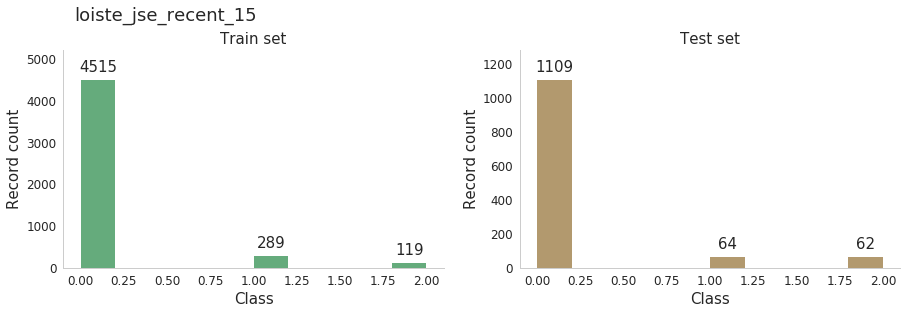

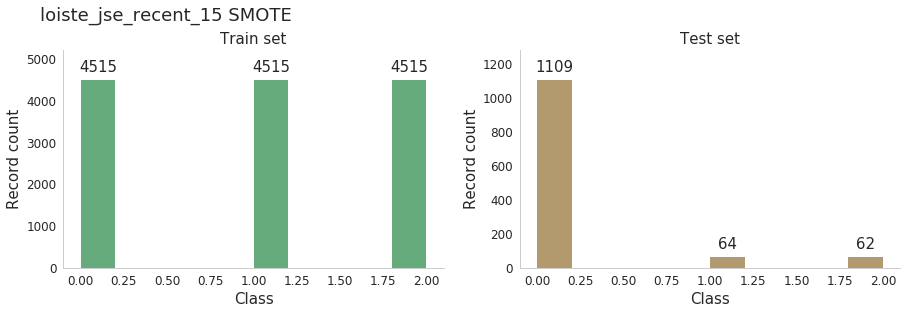

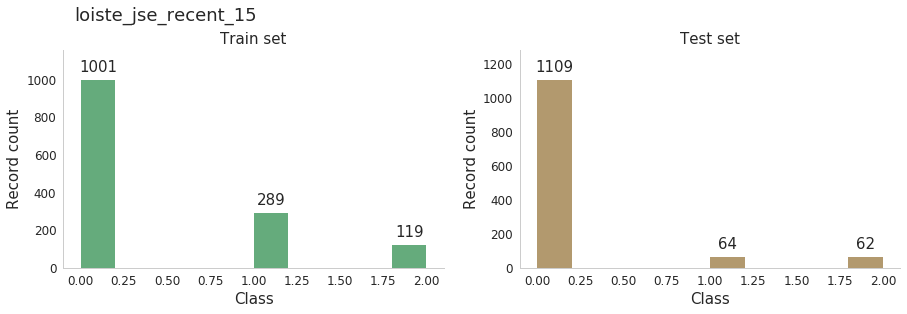

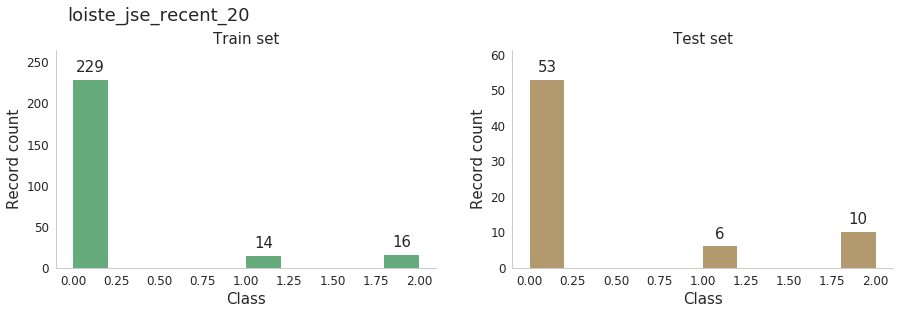

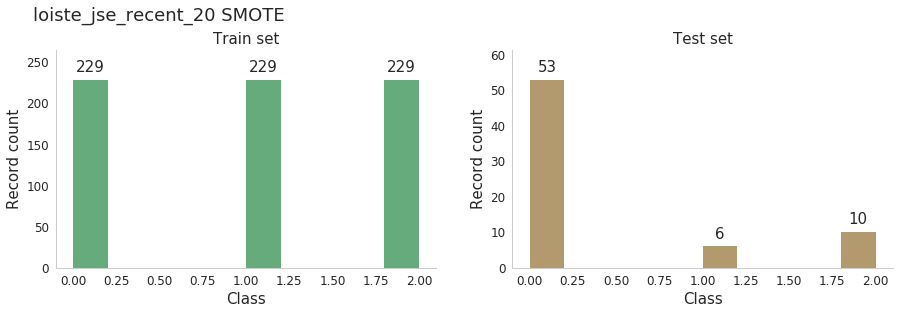

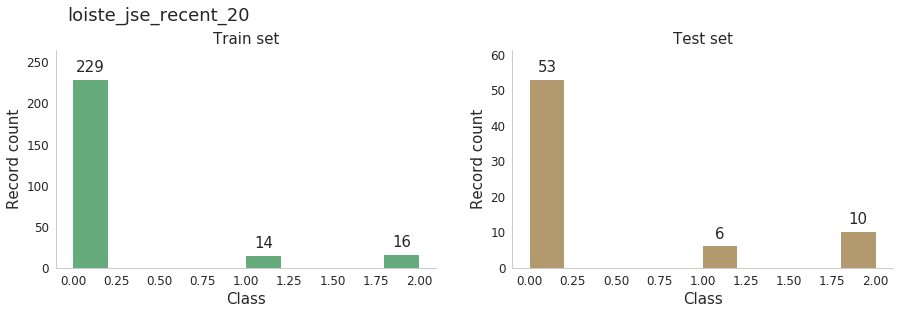

In [11]:
for limit in object_limits:
    name = 'loiste_jse_recent_{}'.format(limit)
    
    plot_class_hist(datasets[name+'_all_train'], datasets[name+'_all_test'], title=name, fontsize=15)
    plot_class_hist(datasets[name+'_all_res'], datasets[name+'_all_test'], title=name+' SMOTE', fontsize=15)

    plot_class_hist(datasets[name+'_small_train'], datasets[name+'_all_test'], title=name, fontsize=15)

In [12]:
datasets_to_save = []
for key, df in datasets.items():
    datasets_to_save.append((key, df))

save_dataset(datasets_to_save)

# Loiste - JSE Random

1. Read whole dataset
1. Re-classify it to three classes. Limit 1-3 for class 1 is selected so that class 1 contain 80 % of all cases with at least 1 outage.
1. Split to train (70 %) and test set (70 %) (randomly)
1. Create smaller training set by limiting class sizes to maximum limit (smaller classes are not affected). Testset remain the same.

In [13]:
#print('All params:')
limits = [(0,0), (1,3), (3, 9999999)]
test_size=.2
shuffle=True
shuffle=False
time_range=None

object_limits = [15, 20]
datasets = {}
scalers = {}
for limit in object_limits:
    name = 'loiste_jse_random_{}'.format(limit)

    ds = get_data('../data/classification_dataset_loiste_jse_forest.csv', 
                  options, 
                  '{}_all'.format(name),
                  verbose=False, 
                  limits=limits,
                  shuffle=shuffle,
                  test_size=test_size,
                  time_range=time_range,
                  limit=limit)
    datasets[name+'_all_train'], datasets[name+'_all_test'], datasets[name+'_all_res'], scalers[name+'_all'] = ds    

    ds =get_data('../data/classification_dataset_loiste_jse_forest.csv', 
                options_thin, 
                '{}_thin'.format(name), 
                verbose=False, 
                limits=limits,
                shuffle=shuffle,
                test_size=test_size,
                time_range=time_range,
                limit=limit)
    datasets[name+'_thin_train'], datasets[name+'_thin_test'], datasets[name+'_thin_res'], scalers[name+'_thin'] = ds    

    datasets[name+'_small_train'] = cut_classes(datasets[name+'_all_train'], [0,1,2], 1000, options.label[0]) 
    datasets[name+'_small_thin_train'] = cut_classes(datasets[name+'_thin_train'], [0,1,2], 1000, options.label[0]) 

Saved scaler scaler ../data/models/scaler/loiste_jse_random_15_all.joblib and uploaded it to models/scaler/loiste_jse_random_15_all.joblib
Saved scaler scaler ../data/models/scaler/loiste_jse_random_15_thin.joblib and uploaded it to models/scaler/loiste_jse_random_15_thin.joblib
Saved scaler scaler ../data/models/scaler/loiste_jse_random_20_all.joblib and uploaded it to models/scaler/loiste_jse_random_20_all.joblib
Saved scaler scaler ../data/models/scaler/loiste_jse_random_20_thin.joblib and uploaded it to models/scaler/loiste_jse_random_20_thin.joblib


In [14]:
for limit in object_limits: 
    name = 'loiste_jse_random_{}'.format(limit)
    dfdup = pd.concat([datasets[name+'_all_train'].loc[:, options.feature_params], datasets[name+'_all_test'].loc[:, options.feature_params]])
    assert len(dfdup[(dfdup.duplicated())]) == 0
    
    name = 'loiste_jse_random_{}'.format(limit)
    dfdup = pd.concat([datasets[name+'_small_thin_train'].loc[:, options_thin.feature_params], datasets[name+'_thin_test'].loc[:, options_thin.feature_params]])
    assert len(dfdup[(dfdup.duplicated())]) == 0
    
    name = 'loiste_jse_random_{}'.format(limit)
    dfdup = pd.concat([datasets[name+'_small_train'].loc[:, options.feature_params], datasets[name+'_all_test'].loc[:, options.feature_params]])
    assert len(dfdup[(dfdup.duplicated())]) == 0

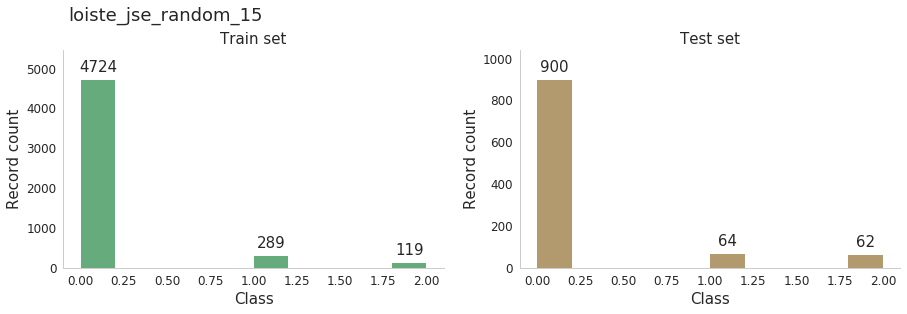

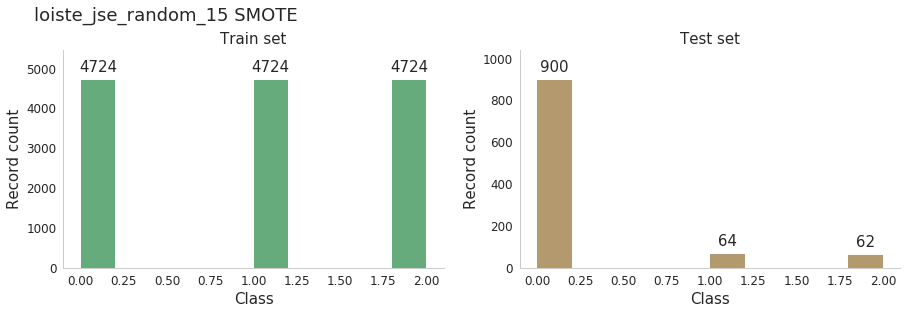

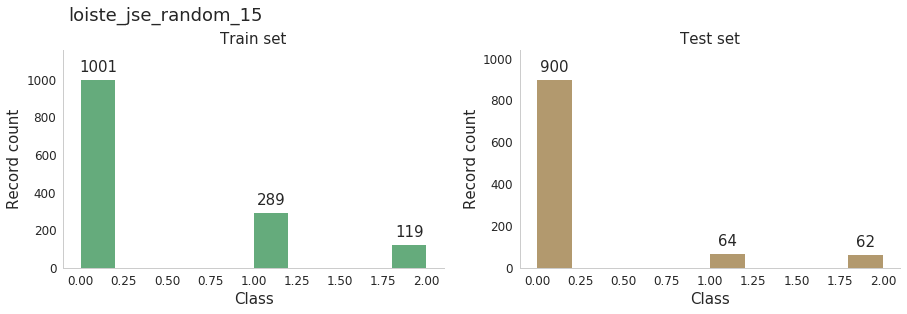

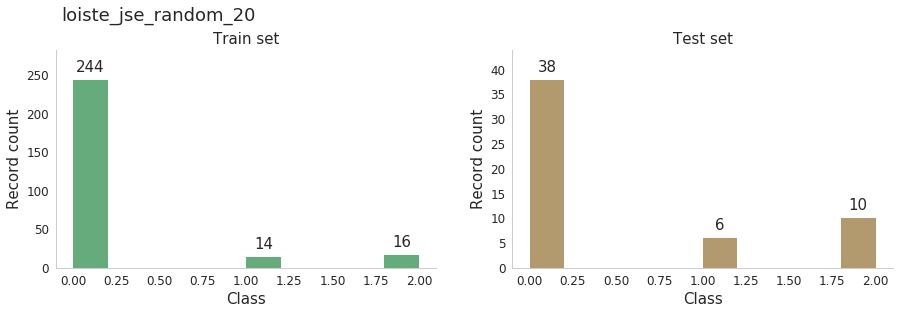

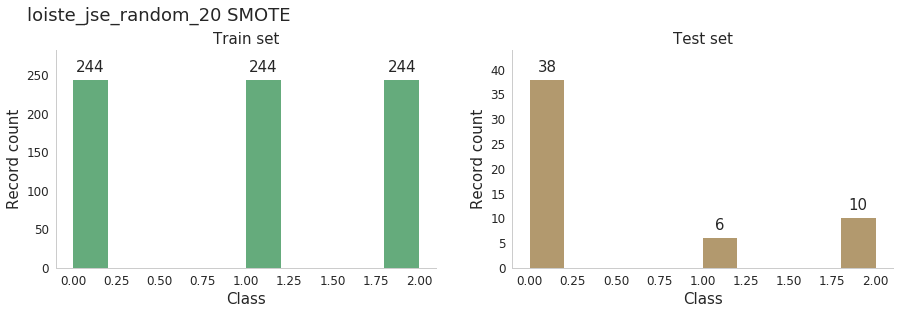

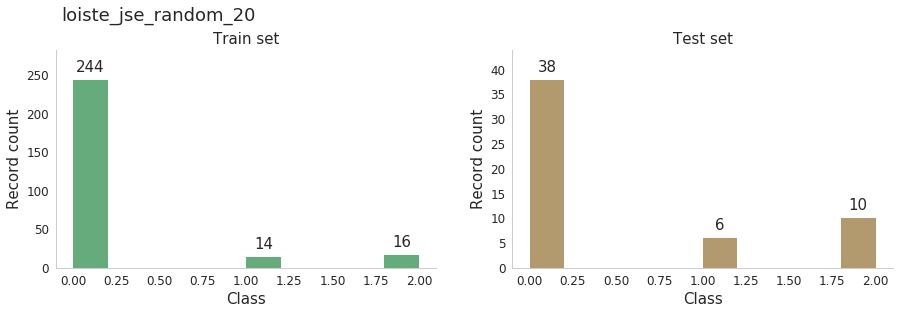

In [15]:
for limit in object_limits:
    name = 'loiste_jse_random_{}'.format(limit)
    
    plot_class_hist(datasets[name+'_all_train'], datasets[name+'_all_test'], title=name, fontsize=15)
    plot_class_hist(datasets[name+'_all_res'], datasets[name+'_all_test'], title=name+' SMOTE', fontsize=15)

    plot_class_hist(datasets[name+'_small_train'], datasets[name+'_all_test'], title=name, fontsize=15)

In [16]:
datasets_to_save = []
for key, df in datasets.items():
    datasets_to_save.append((key, df))

save_dataset(datasets_to_save)

# Energiateollisuus 2010-2011

In [22]:
class Options(): pass

options = Options()
options.config_filename = '../cnf/rfc.ini'
options.config_name = 'forest_energiateollisuus'
read_options(options)

options_thin = Options()
options_thin.config_filename = '../cnf/rfc.ini'
options_thin.config_name = 'thin_energiateollisuus'
read_options(options_thin)

In [18]:
# Ensure that 1-3 outages cover 80 % of all outages cases
data = pd.read_csv('../data/classification_dataset_energiateollisuus_forest.csv')
print(len(data[(data['outages'] > 0) & (data['outages'] < 140)])/len(data[(data['outages'] > 0)]))
print(len(data[(data['outages'] == 0)])/len(data))
print(len(data[(data['outages'] > 0) & (data['outages'] < 140)])/len(data))

0.8068877777449037
0.7634332589082612
0.19088281200786714


In [26]:
limits = [(0,0), (1,140), (140, 9999999)]
test_size=.1
shuffle=False
time_range=('2010-01-01', '2010-12-31')

object_limits = [15, 20]
datasets = {}
scalers = {}

for limit in object_limits:
    name = 'energiateollisuus_recent_{}'.format(limit)

    ds = get_data('../data/classification_dataset_energiateollisuus_forest.csv', 
                  options, 
                  '{}_all'.format(name),
                  verbose=False, 
                  limits=limits,
                  shuffle=shuffle,
                  test_size=test_size,
                  time_range=time_range,
                  limit=limit)
    datasets[name+'_all_train'], datasets[name+'_all_test'], datasets[name+'_all_res'], scalers[name+'_all'] = ds    

    ds =get_data('../data/classification_dataset_energiateollisuus_forest.csv', 
                options_thin, 
                '{}_thin'.format(name), 
                verbose=False, 
                limits=limits,
                shuffle=shuffle,
                test_size=test_size,
                time_range=time_range,
                limit=limit)
    datasets[name+'_thin_train'], datasets[name+'_thin_test'], datasets[name+'_thin_res'], scalers[name+'_thin'] = ds    

    datasets[name+'_small_train'] = cut_classes(datasets[name+'_all_train'], [0,1,2], 1000, options.label[0]) 
    datasets[name+'_small_thin_train'] = cut_classes(datasets[name+'_thin_train'], [0,1,2], 1000, options.label[0]) 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Saved scaler scaler ../data/models/scaler/energiateollisuus_recent_15_all.joblib and uploaded it to models/scaler/energiateollisuus_recent_15_all.joblib


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Saved scaler scaler ../data/models/scaler/energiateollisuus_recent_15_thin.joblib and uploaded it to models/scaler/energiateollisuus_recent_15_thin.joblib


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Saved scaler scaler ../data/models/scaler/energiateollisuus_recent_20_all.joblib and uploaded it to models/scaler/energiateollisuus_recent_20_all.joblib


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Saved scaler scaler ../data/models/scaler/energiateollisuus_recent_20_thin.joblib and uploaded it to models/scaler/energiateollisuus_recent_20_thin.joblib


In [27]:
for limit in object_limits: 
    name = 'energiateollisuus_recent_{}'.format(limit)
    dfdup = pd.concat([datasets[name+'_all_train'].loc[:, options.feature_params], datasets[name+'_all_test'].loc[:, options.feature_params]])
    assert len(dfdup[(dfdup.duplicated())]) == 0
    
    name = 'energiateollisuus_recent_{}'.format(limit)
    dfdup = pd.concat([datasets[name+'_small_thin_train'].loc[:, options_thin.feature_params], datasets[name+'_thin_test'].loc[:, options_thin.feature_params]])
    assert len(dfdup[(dfdup.duplicated())]) == 0
    
    name = 'energiateollisuus_recent_{}'.format(limit)
    dfdup = pd.concat([datasets[name+'_small_train'].loc[:, options.feature_params], datasets[name+'_all_test'].loc[:, options.feature_params]])
    assert len(dfdup[(dfdup.duplicated())]) == 0

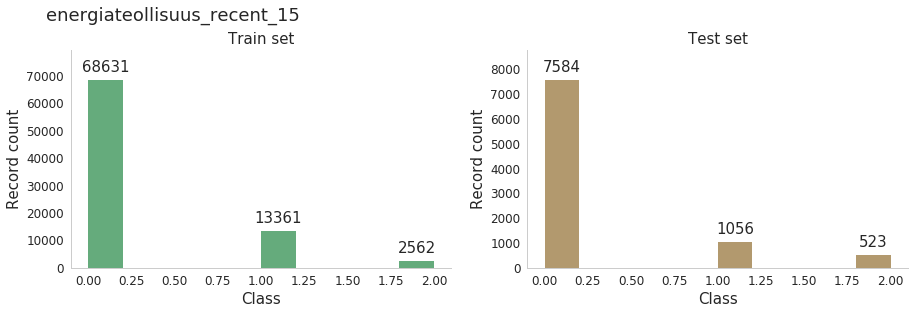

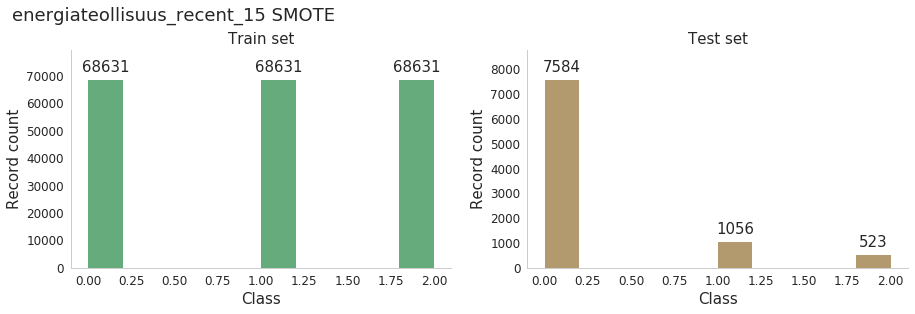

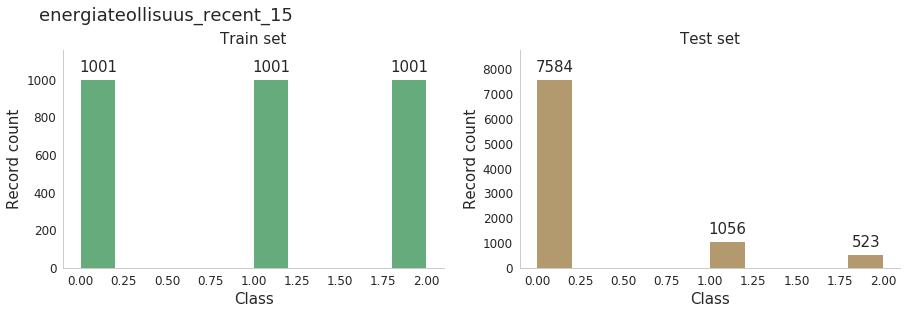

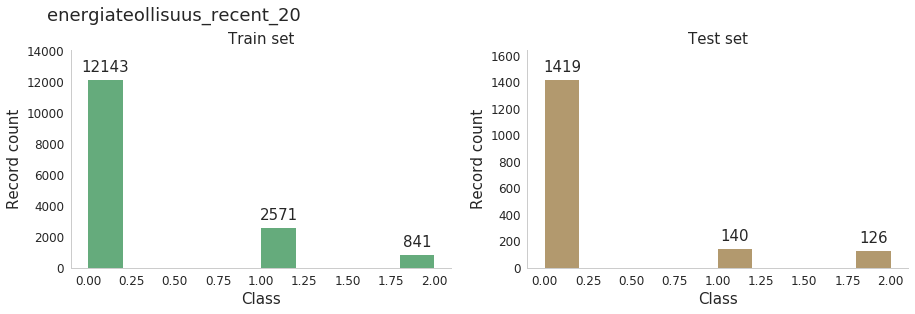

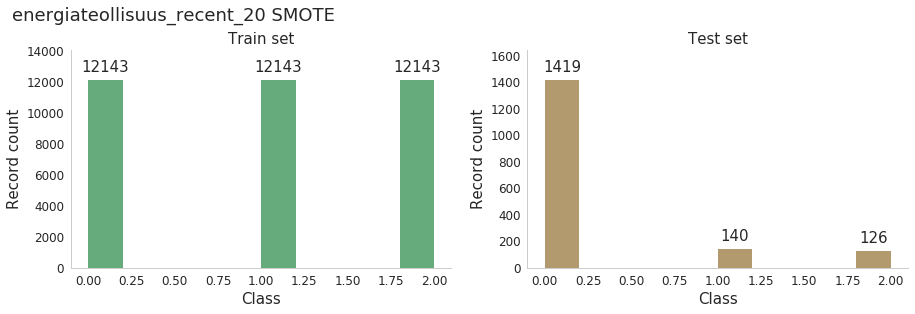

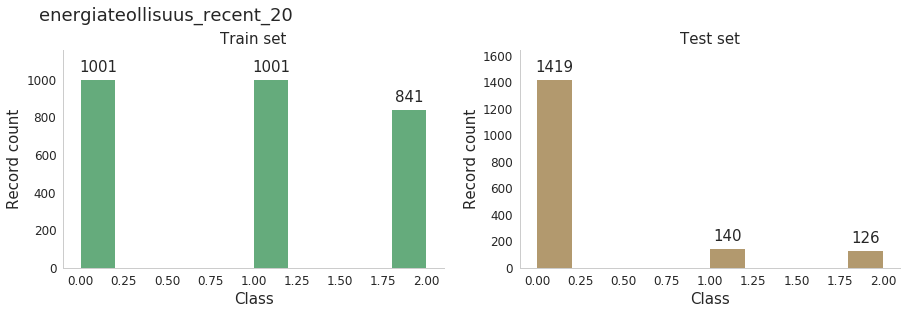

In [28]:
for limit in object_limits:
    name = 'energiateollisuus_recent_{}'.format(limit)
    
    plot_class_hist(datasets[name+'_all_train'], datasets[name+'_all_test'], title=name, fontsize=15)
    plot_class_hist(datasets[name+'_all_res'], datasets[name+'_all_test'], title=name+' SMOTE', fontsize=15)

    plot_class_hist(datasets[name+'_small_train'], datasets[name+'_all_test'], title=name, fontsize=15)

In [29]:
datasets_to_save = []
for key, df in datasets.items():
    datasets_to_save.append((key, df))

save_dataset(datasets_to_save)

# Energiateollisuus random

In [30]:
limits = [(0,0), (1,140), (140, 9999999)]
test_size=.2
shuffle=True
time_range=None

object_limits = [15, 20]
datasets = {}
scalers = {}

for limit in object_limits:
    name = 'energiateollisuus_random_{}'.format(limit)

    ds = get_data('../data/classification_dataset_energiateollisuus_forest.csv', 
                  options, 
                  '{}_all'.format(name),
                  verbose=False, 
                  limits=limits,
                  shuffle=shuffle,
                  test_size=test_size,
                  time_range=time_range,
                  limit=limit)
    datasets[name+'_all_train'], datasets[name+'_all_test'], datasets[name+'_all_res'], scalers[name+'_all'] = ds    

    ds =get_data('../data/classification_dataset_energiateollisuus_forest.csv', 
                options_thin, 
                '{}_thin'.format(name), 
                verbose=False, 
                limits=limits,
                shuffle=shuffle,
                test_size=test_size,
                time_range=time_range,
                limit=limit)
    datasets[name+'_thin_train'], datasets[name+'_thin_test'], datasets[name+'_thin_res'], scalers[name+'_thin'] = ds    

    datasets[name+'_small_train'] = cut_classes(datasets[name+'_all_train'], [0,1,2], 1000, options.label[0]) 
    datasets[name+'_small_thin_train'] = cut_classes(datasets[name+'_thin_train'], [0,1,2], 1000, options.label[0]) 

Saved scaler scaler ../data/models/scaler/energiateollisuus_random_15_all.joblib and uploaded it to models/scaler/energiateollisuus_random_15_all.joblib
Saved scaler scaler ../data/models/scaler/energiateollisuus_random_15_thin.joblib and uploaded it to models/scaler/energiateollisuus_random_15_thin.joblib
Saved scaler scaler ../data/models/scaler/energiateollisuus_random_20_all.joblib and uploaded it to models/scaler/energiateollisuus_random_20_all.joblib
Saved scaler scaler ../data/models/scaler/energiateollisuus_random_20_thin.joblib and uploaded it to models/scaler/energiateollisuus_random_20_thin.joblib


In [31]:
for limit in object_limits: 
    name = 'energiateollisuus_random_{}'.format(limit)
    dfdup = pd.concat([datasets[name+'_all_train'].loc[:, options.feature_params], datasets[name+'_all_test'].loc[:, options.feature_params]])
    assert len(dfdup[(dfdup.duplicated())]) == 0
    
    name = 'energiateollisuus_random_{}'.format(limit)
    dfdup = pd.concat([datasets[name+'_small_thin_train'].loc[:, options_thin.feature_params], datasets[name+'_thin_test'].loc[:, options_thin.feature_params]])
    assert len(dfdup[(dfdup.duplicated())]) == 0
    
    name = 'energiateollisuus_random_{}'.format(limit)
    dfdup = pd.concat([datasets[name+'_small_train'].loc[:, options.feature_params], datasets[name+'_all_test'].loc[:, options.feature_params]])
    assert len(dfdup[(dfdup.duplicated())]) == 0

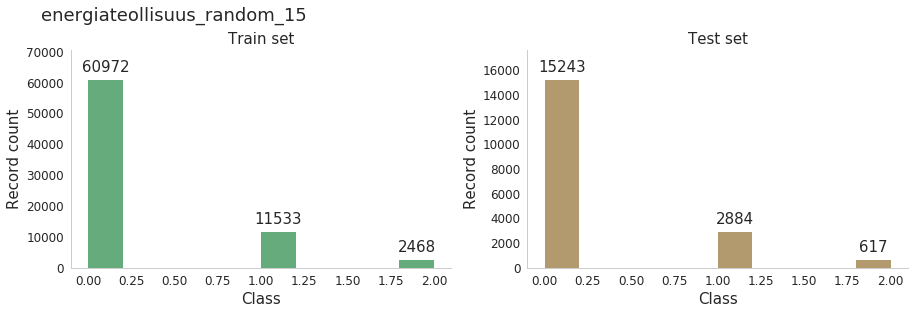

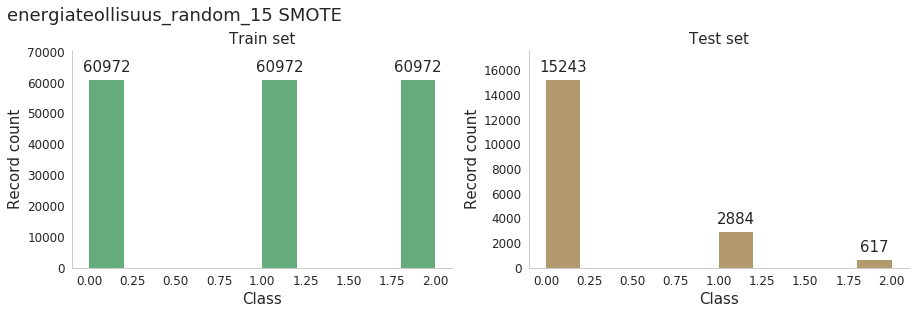

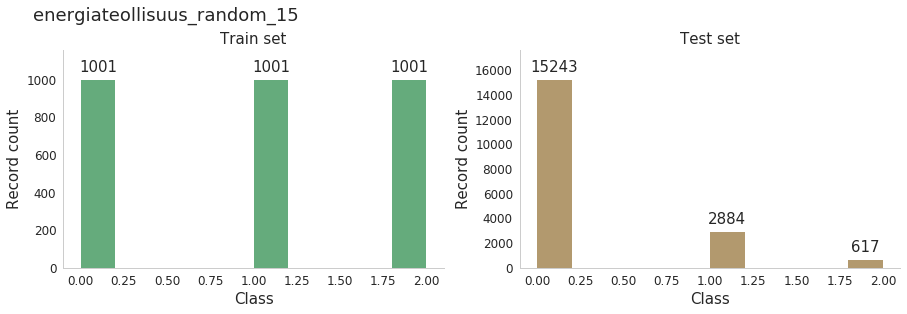

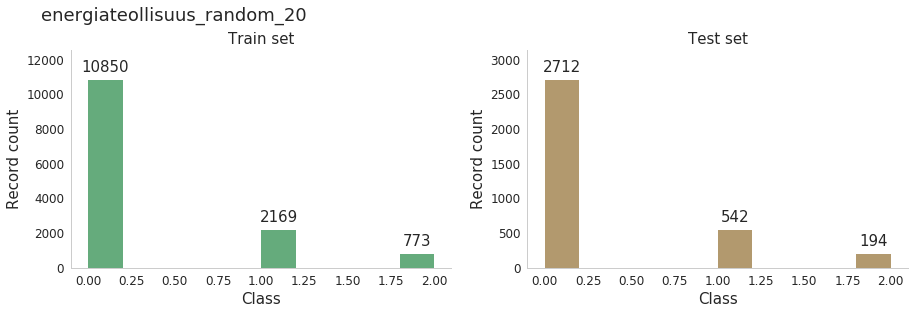

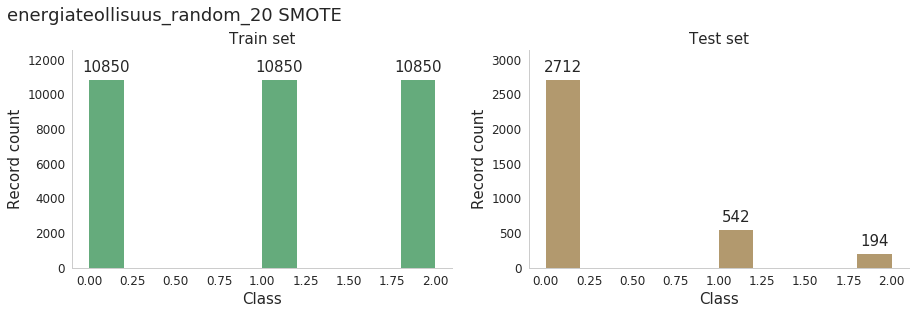

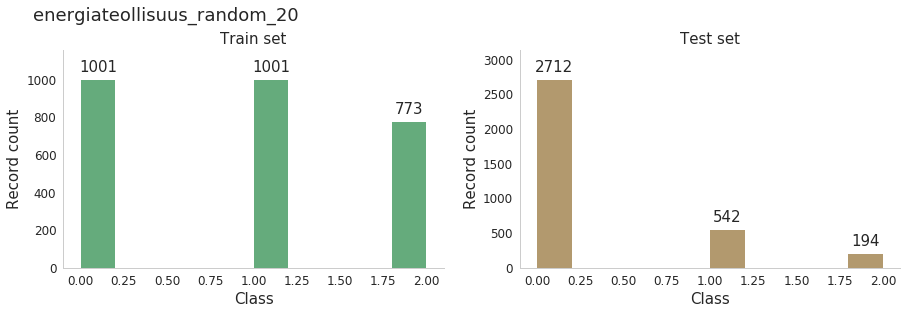

In [32]:
for limit in object_limits:
    name = 'energiateollisuus_random_{}'.format(limit)
    
    plot_class_hist(datasets[name+'_all_train'], datasets[name+'_all_test'], title=name, fontsize=15)
    plot_class_hist(datasets[name+'_all_res'], datasets[name+'_all_test'], title=name+' SMOTE', fontsize=15)

    plot_class_hist(datasets[name+'_small_train'], datasets[name+'_all_test'], title=name, fontsize=15)

In [33]:
datasets_to_save = []
for key, df in datasets.items():
    datasets_to_save.append((key, df))

save_dataset(datasets_to_save)